In [7]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.nn import functional as F
import os, json, time
from pathlib import Path

# hyperparameters
batch_size = 64 # increased to have more stable layer normalization statistics
block_size = 32 # context length
eval_interval = 50 
learning_rate = 1e-3 #initial learning rate, will be scheduled
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 250
n_embd = 100 # now we have an embedding dimension (one hot encoding is replaced by learned continuous vectors)
n_heads = 4 #number of heads in multi-head attention
n_hidden=2*n_embd
patience = 10 #for learning rate scheduler
max_iters = 5000
# -------------------------

# tinyshakespeare dataset
# !curl -O https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt #load it once
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
#encoder and decoder
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] #take a string -> output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) #take a list of integers -> output a string

# data
data = torch.tensor(encode(text), dtype=torch.long) #convert to tensor
n = int(0.9 * len(data)) #90% for training, 10% for validation
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    # generate a small, random batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) #next character is the target
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()

    model.train()
    return out

# single head self-attention
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # store lower triangular matrix

        self.dropout = nn.Dropout(dropout) 

    def forward(self, x):
        B, T, C = x.shape
        k, q, v = self.key(x), self.query(x), self.value(x)

        #compute attention affinities
        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5 # --> (B, T, T); note the scaling factor
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        out = wei @ v # (B, T, head_size) --- this is Eq. (1) in the Attention is All You Need paper 
        return out
    
class MultiHead(nn.Module):
    """ 
        multiple heads of self-attention in parallel;
        based on the modular single head implementation above, see Head() 
    """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class FeedForward(nn.Module):
    #a single linear layer followed by GeLu
    def __init__(self, n_embd, n_hidden=4*n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_hidden),
            nn.GELU(), # smoother than ReLU, standard in modern Transformer blocks
            nn.Linear(n_hidden, n_embd), #projection layer
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class TransformerBlock(nn.Module):
    """
    multi-head attention block followed by a nn layer
    added residual connections
    """

    def __init__(self, n_embd, n_head, n_hidden=4*n_embd):
        super().__init__()
        head_size = n_embd // n_head
        self.sa_heads = MultiHead(num_heads=n_head, head_size=head_size)
        self.ffwd = FeedForward(n_embd, n_hidden=n_hidden)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class FullModel(nn.Module):
    # progressively build the full language model --> here, we add Transformer Blocks

    def __init__(self, num_heads=4, n_hidden=4*n_embd, num_blocks=3):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # note the addition of positional encoding (the only way the model knows the order of the sequence )
        self.blocks = nn.ModuleList([
            TransformerBlock(n_embd, num_heads, n_hidden=n_hidden)
            for _ in range(num_blocks)
        ])
        self.ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embd)
        x = tok_emb + pos_emb # (B, T, n_embd) 
        for block in self.blocks:
            x = block(x)          # (B, T, n_embd)
        x = self.ln(x) #layer norm before the final projection
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:    
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            ind_cond = idx[:, -block_size:] 
            logits, _ = self(ind_cond)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1)           # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)     # (B, T+1)
        return idx

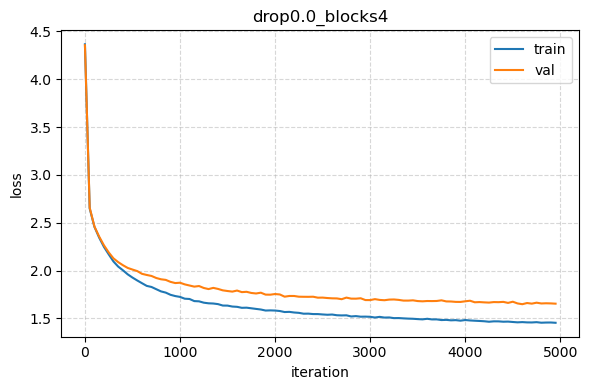

In [8]:
import matplotlib.pyplot as plt

dropout = 0.0
run_name = "drop0.0_blocks4"     # best run
curve_path = Path(f"artifacts/curves/{run_name}_curves.json")
ckpt_path = Path(f"artifacts/checkpoints/{run_name}_best.pt")
ckpt = torch.load(ckpt_path, map_location=device)
cfg = ckpt["config"]
model = FullModel(
    num_heads=cfg["n_heads"],
    n_hidden=2 * cfg["n_embd"],
    num_blocks=cfg["num_blocks"]
).to(device)

model.load_state_dict(ckpt["model_state"])

with open(curve_path, "r") as f:
    curve = json.load(f)

iters = [d["iter"] for d in curve]
train_loss = [d["train"] for d in curve]
val_loss = [d["val"] for d in curve]

# plot
plt.figure(figsize=(6,4))
plt.plot(iters, train_loss, label="train")
plt.plot(iters, val_loss, label="val")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title(run_name)
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
# generate from the model:
idx = torch.zeros((1, 1), dtype=torch.long, device=device) # starting context
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


Then was speak leves say alace, sir?

DUCHESS OF Ducester: but no man too
Doo priviled by that know I amile.
For King Henry, untation that letting for the past.

DUKE VINCENTIO:
Foor and I'll duble blood, though aignstraw'st flesh and lived in
concluction's par.
'How tell that honour to desppected
Which never soul dishonly little morning;
Know that Hath forsom tate't indest
That lamble chiff, you having fingerous:
It be strike paties of this toman,
Ha! What, on thessess pitch. Do thou, by Saint 
